<a href="https://colab.research.google.com/github/ArshiAbolghasemi/AI-UT/blob/main/neural_network/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will utilize a text dataset to demonstrate advanced natural language processing techniques. Our approach will involve initial preprocessing of the text, followed by the application of Word2Vec and neural networks to effectively analyze and interpret the data. Through these methods, we aim to uncover meaningful patterns and insights within the text.

# Imports and Settings

## Imports

In [3]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.9 MB/s eta 0:00:00


In [39]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from emoji import demojize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
from random import randint, random
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsummary import summary
from time import time

## Settings

In [5]:
DRIVE_MOUNTED_PATH=os.path.join(os.getcwd(), 'drive/')
TWITTER_SUICIDAL_DATASET_PATH=os.path.join(DRIVE_MOUNTED_PATH, 'MyDrive/AI-UT/neural_network/twitter-suicidal-data.csv')

## Device Configuration

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Mounting to Google Drive

In [7]:
drive.mount(DRIVE_MOUNTED_PATH)

Mounted at /content/drive/


# Data Preprocessing

## Reading Dataset

In [8]:
twitter_suicidal_data = pd.read_csv(TWITTER_SUICIDAL_DATASET_PATH)

In [9]:
twitter_suicidal_data

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
...,...,...
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1


In [10]:
twitter_suicidal_data_cleaned = twitter_suicidal_data.copy()

## Convert to lowercase

Converting all text to lowercase ensures uniformity. It helps in matching words correctly regardless of their case, reducing redundancy (e.g., "Python" and "python" are considered the same word).
<br>
Pros:
- **Normalization**: Converting text to lowercase helps normalize the text by ensuring consistency. It treats words with different cases (e.g., "Hello", "hello", "HELLO") as the same, which can simplify text processing and analysis.

- **Reduced Vocabulary Size**: Lowercasing reduces the number of distinct tokens in the text, which can improve the efficiency of downstream tasks such as tokenization, indexing, and modeling. This is particularly beneficial for tasks with limited computational resources.

- **Improved Matching**: Lowercasing facilitates case-insensitive matching. This is useful in tasks such as search, comparison, and retrieval, where case sensitivity might not be desired or necessary.

- **Standardization**: Lowercasing helps standardize text data, making it consistent across different sources, systems, and languages. It ensures that text processing pipelines produce consistent results regardless of the original casing.

Cons:
- **Loss of Information**: Lowercasing can lead to the loss of information, especially in cases where the distinction between uppercase and lowercase letters is semantically meaningful. For example, proper nouns, acronyms, and emphasis can be lost when converted to lowercase.

- **Misinterpretation of Entities**: Lowercasing can potentially alter the interpretation of named entities (e.g., "USA" to "usa"), leading to ambiguity or misinterpretation in text analysis tasks, such as named entity recognition or entity disambiguation.

- **Loss of Emphasis**: Lowercasing removes emphasis conveyed by uppercase letters, which might be important for conveying tone, emphasis, or significance in the text. This can affect tasks such as sentiment analysis or text summarization.

## Remove Punctuation

Punctuation marks are generally not useful in most text analysis tasks (e.g., sentiment analysis) and can be removed to focus on the words themselves. This step simplifies tokenization and text processing.

## Removing Numbers

Numbers in text data, especially from social media, can be noisy and might not contribute meaningfully to the analysis. For example, random numbers, dates, and phone numbers often do not hold significant value in text sentiment analysis or other NLP tasks.
<br>
Pros:
- **Improved Text Clarity**: Removing numbers can make the text clearer and more readable, especially in tasks like sentiment analysis, topic modeling, or text summarization, where numbers might not contribute to the overall meaning.

- **Reduced Vocabulary Size**: By eliminating numbers, you reduce the size of the vocabulary, which can simplify text processing tasks such as tokenization, indexing, and modeling. This can lead to more efficient algorithms and reduced computational overhead.

- **Focused Analysis**: In some cases, numbers are noise that distracts from the main content of the text. By removing them, you can focus your analysis on the relevant textual information, leading to more accurate results.

Cons:
- **Loss of Information**: Removing numbers may result in the loss of valuable information, especially in contexts where numerical data is significant, such as financial reports, scientific documents, or technical manuals. The presence of numbers can convey quantitative information, dates, measurements, or other important details.

- **Altered Meaning**: In certain text analysis tasks, such as sentiment analysis or opinion mining, numbers may carry emotional or contextual significance. Removing them could potentially alter the meaning or sentiment of the text, leading to misinterpretation.

- **Impact on Tasks**: Removing numbers may not be suitable for all tasks or datasets. In some cases, such as text classification based on numerical patterns or sentiment analysis of numerical reviews, preserving numbers might be essential for accurate analysis.

## Remove URLs

URLs are often not useful for text analysis and can introduce noise. They usually don't contribute to the sentiment or meaning of the tweet and can be safely removed to focus on the actual content.

## Remove Mentions

Mentions (e.g., @elonmusk) are specific to Twitter and do not usually contribute to the semantic content of the text. Removing them helps in focusing on the message rather than the addressed users.

## Remove Emojis

Emojis can convey sentiment and meaning, but they might complicate text processing. If the analysis does not benefit from emojis, removing them can simplify the text. However, if you are interested in the sentiment or emotional content, you might want to keep them or replace them with corresponding text descriptions.

## Space Uniformity


Ensuring uniformity of spaces is an important step in text preprocessing. It involves removing extra spaces, leading and trailing spaces, and ensuring that words are properly separated by a single space. This helps in maintaining consistency and avoiding potential issues in tokenization or further analysis.

## Tokenize

Tokenization splits the text into individual words (tokens). This is a crucial step for many text processing tasks like filtering out stopwords, analyzing word frequencies, and further text analysis.



## Remove Stopwords

Stopwords (e.g., "and", "is", "in") are common words that usually do not carry significant meaning and can be removed to focus on the more meaningful words. This reduces the dimensionality of the data and improves analysis efficiency.

## Remove Hashtags

Preserving hashtags in suicidal tweets can provide valuable contextual information and improve model accuracy in certain cases, but it also carries risks of introducing noise, overfitting, and ethical concerns. The impact on model accuracy depends on various factors, including the quality of the data, the task at hand, and the design of the model. Therefore, it's crucial to carefully evaluate the trade-offs and implications of preserving hashtags in suicidal tweets and to adopt appropriate strategies for mitigating potential risks while maximizing the benefits of contextual information.

## Implementation

In [11]:
# Download Stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
def preprocess_tweet(tweet):
  tweet = tweet.lower()
  tweet = re.sub(r'[^\w\s]', '', tweet)
  tweet = re.sub(r'\d+', '', tweet)
  tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
  tweet = re.sub(r'@\w+', '', tweet)
  tweet = demojize(tweet)
  tweet = re.sub(r'\s+', ' ', tweet).strip()
  return tweet

In [13]:
def tokenize_cleaned_tweet(cleaned_tweet):
  tokens = word_tokenize(cleaned_tweet)
  tokens = [word for word in tokens if word not in stopwords.words('english')]
  return tokens

In [14]:
twitter_suicidal_data_cleaned['cleaned_tweet'] = twitter_suicidal_data_cleaned['tweet'].apply(preprocess_tweet)

In [15]:
sample_tweet = twitter_suicidal_data_cleaned.sample(n=5)

In [16]:
sample_tweet['tweet'].head()

139     only 15 and boy am i done with life i just can...
7523                                        i want to die
7829    this is absolutely not to be construed as a de...
1428    in case someone finds this after i died my lif...
1638    they say tomorrow is a new day but everyday is...
Name: tweet, dtype: object

In [17]:
sample_tweet['cleaned_tweet'].head()

139     only and boy am i done with life i just cant t...
7523                                        i want to die
7829    this is absolutely not to be construed as a de...
1428    in case someone finds this after i died my lif...
1638    they say tomorrow is a new day but everyday is...
Name: cleaned_tweet, dtype: object

In [18]:
twitter_suicidal_data_cleaned['tokens'] = twitter_suicidal_data_cleaned['cleaned_tweet'].apply(tokenize_cleaned_tweet)

## Describe Result

In [19]:
twitter_suicidal_data_cleaned.head()

,tweet,intention,cleaned_tweet,tokens
0,my life is meaningless i just want to end my l...,1,my life is meaningless i just want to end my l...,"[life, meaningless, want, end, life, badly, li..."
1,muttering i wanna die to myself daily for a fe...,1,muttering i wanna die to myself daily for a fe...,"[muttering, wan, na, die, daily, months, feel,..."
2,work slave i really feel like my only purpose ...,1,work slave i really feel like my only purpose ...,"[work, slave, really, feel, like, purpose, lif..."
3,i did something on the 2 of october i overdose...,1,i did something on the of october i overdosed ...,"[something, october, overdosed, felt, alone, h..."
4,i feel like no one cares i just want to die ma...,1,i feel like no one cares i just want to die ma...,"[feel, like, one, cares, want, die, maybe, fee..."


In [20]:
twitter_suicidal_data_cleaned['token_count'] = twitter_suicidal_data_cleaned['tokens'].apply(len)

In [ ]:
result = twitter_suicidal_data_cleaned.groupby('intention')['token_count'].agg(['mean', 'max', 'min'])
print(result)

                mean   max  min
intention                      
0           8.976567    38    0
1          73.848424  2147    1


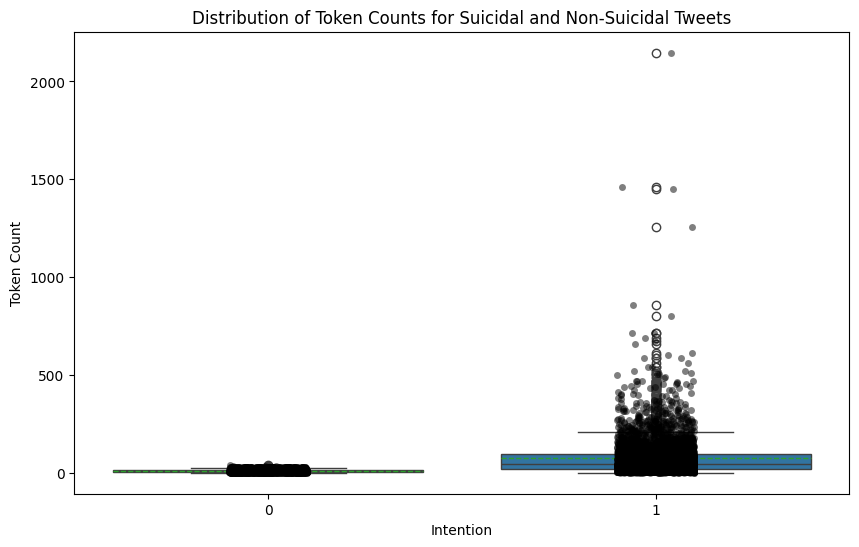

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=twitter_suicidal_data_cleaned, x='intention', y='token_count', showmeans=True, meanline=True)
sns.stripplot(data=twitter_suicidal_data_cleaned, x='intention', y='token_count', jitter=True, color='black', alpha=0.5)
plt.title('Distribution of Token Counts for Suicidal and Non-Suicidal Tweets')
plt.xlabel('Intention')
plt.ylabel('Token Count')
plt.show()

# Feature Vectors

## Word Embedding

Word embeddings are basically representations where contexts and similarities are captured by encoding in a vector space- similar words would have similar representations

## Word2Vec

In [22]:
w2v = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Padding

Padding involves adding extra tokens or values to sequences to make them all have the same length. This is often necessary because many machine learning models expect inputs of fixed dimensions. When working with sequences, such as sentences in natural language processing or time series data, it's common to have sequences of different lengths. Padding helps ensure that all sequences are of equal length.

- **Zero-Padding**: is a specific type of padding where the extra values added to the sequences are zeros. Zero-padding is widely used because it has minimal impact on the data's original meaning, especially in scenarios like text processing where zero indices don't represent any actual words.

## Out of Vocabulary Words(OOV Words)



1.   **Zero-Padding**

 **Pros**:

  *   Simple and easy to implement.
  *   Preserves the structure of the input data.
  *   Zero vectors don't introduce additional parameters to the model.

 **Cons**:
  *   Loss of information: Zero vectors do not convey any semantic meaning, potentially leading to loss of valuable information.
  *  Ineffective for unseen words: Similarity calculations involving OOV words will be inaccurate, as all OOV words are treated the same.


2.   **Random Vectors**

  **Pros**:
  
    * Preserves input dimensionality.
    * Provides some representation for OOV words.
    * Can be useful when dealing with small datasets or rare words.

  **Cons**:
    * Lack of semantic meaning: Random vectors do not capture any meaningful information about the words.
    * Not deterministic: The representations for OOV words will vary randomly during each training session, making it challenging to learn meaningful patterns.

3.  **Subword Embeddings**

  **Pros**

    * Handles OOV words by decomposing words into subword units (n-grams), allowing for the creation of embeddings for unseen words based on their subword components.
    * Effective for handling morphologically rich languages and rare words.
    * Captures more fine-grained information compared to word-level embeddings.

  **Cons**

    * Increased computational complexity: Training and inference with subword embeddings can be computationally more expensive than traditional word embeddings.
    * Larger memory footprint: Subword embeddings typically require more memory to store due to the increased vocabulary size.

4. **Character-Level Embeddings**

  **Pros**:

    * Generates embeddings directly from characters, allowing the model to learn representations for unseen words based on their character compositions.
    * Effective for handling misspellings, morphological variations, and rare words.
    * Encodes subword information, making it robust to unseen words and languages with complex morphology.
    
  **Cons**:

    * Increased model complexity: Character-level embeddings require more parameters and computational resources compared to word-level embeddings.
    * Longer training time: Training character-level embeddings can be slower due to the increased dimensionality of the input data.
5. **OOV Word Handling Strategies during Training**
  
  **Pros**:

    * Adaptive approach: Dynamically updates word representations during training based on the context and similarity to known words.
    * Provides a more nuanced representation for OOV words compared to fixed methods like zero or random vectors.
    * Can be combined with other techniques for improved performance.

  **Cons**:

    * Complexity: Requires specialized algorithms and additional training procedures to handle OOV words effectively.
    * Risk of overfitting: Adapting representations for OOV words based on limited context may lead to overfitting, especially in data-poor scenarios.


## Implementation

In [23]:
def get_tweet_features_vector(tweet_tokens, tweet_token_length=64,
                             token_feature_vector_len=w2v.vector_size,
                             model=w2v):
  tweet_vectors = np.zeros((tweet_token_length, token_feature_vector_len))
  for idx, token in enumerate(tweet_tokens[:tweet_token_length]):
    if not token in model.key_to_index:
      continue

    tweet_vectors[idx] = model[token]

  return tweet_vectors

In [24]:
tweet_features_vector = twitter_suicidal_data_cleaned['tokens'].apply(get_tweet_features_vector)

In [25]:
tweet_features_vector

0       [[-0.06787109375, 0.09521484375, 0.03564453125...
1       [[0.234375, -0.02294921875, 0.1826171875, 0.12...
2       [[-0.07568359375, 0.03369140625, -0.0649414062...
3       [[0.1123046875, 0.018310546875, 0.0771484375, ...
4       [[-0.0556640625, 0.01373291015625, -0.14160156...
                              ...                        
9114    [[-0.2255859375, -0.032470703125, 0.0402832031...
9115    [[-0.02490234375, -0.37890625, 0.330078125, 0....
9116    [[-0.057861328125, 0.01318359375, 0.115234375,...
9117    [[0.02392578125, -0.046142578125, 0.00390625, ...
9118    [[-0.1240234375, 0.2470703125, 0.0218505859375...
Name: tokens, Length: 9119, dtype: object

# Classification using CNN

## Optimization using ADAM

1. **Initialization**:
  *   Initializes two moving average vectors: $m$ (first moment) and $v$ (second moment) to zero
  *  Initializes hyperparameters: learning rate $α$, decay rates $β_1, β_2$
 , and a small constant $\epsilon$ to prevent division by zero.

2. **Gradient Computation**:
  * Computes gradients $g_t$ at each time step $t$ using backpropagation.

3. **Update Biased Moment Estimates**:
  * Updates the biased first moment estimate:
  $$
  m_t = β_1m_{t-1} + (1- β_1)g_t
  $$
  * Updates the biased second moment estimate:
  $$
  v_t = β_2v_{t-1} + (1- β_2)g_t^2
  $$
4. **Bias Correction**:
  * Corrects the bias in the first moment estimate:
  $$
  \hat{m}_t = \frac{m_t}{1 - β_1^t}
  $$
  * Corrects the bias in the second moment estimate:
  $$
  \hat{v}_t = \frac{v_t}{1 - β_2^t}
  $$
5. **Update Parameters:**
  * Updates the parameters $θ$ using the bias-corrected estimates:
  $$
  θ_t = θ_{t-1} - α\frac{\hat{m_t}}{\sqrt{\hat{v_t}} + ϵ}
  $$



| Aspect               | Adam                                                                                                    | SGD                                                                                           |
|----------------------|---------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Initialization**   | Initializes two moving average vectors \( m \) and \( v \) to zero.                                      | No moving average initialization.                                                            |
| **Gradient Update**  | Updates parameters using biased first and second moment estimates.                                       | Directly uses gradients computed from the current batch of data.                              |
| **Learning Rate**    | Adaptive learning rates for each parameter, adjusting individually based on the first and second moments.| Uses a fixed learning rate for all parameters.                                                |
| **Gradient Estimation** | Uses moving averages of gradients and squared gradients (first and second moments) for stabilization.   | Does not use moving averages, directly utilizes gradients.                                    |
| **Bias Correction**  | Corrects bias introduced by moving averages using bias-corrected estimates.                              | No bias correction applied.                                                                   |
| **Hyperparameters**  | Involves multiple hyperparameters: learning rate \( \alpha \), decay rates \( \beta_1 \) and \( \beta_2 \), and a small constant \( \epsilon \). | Mainly involves tuning the learning rate.                                                      |
| **Convergence**      | Generally converges faster and is more robust to hyperparameter settings.                                | Can be sensitive to the choice of learning rate and may require careful tuning.                |


## Loss Function(Cross Entropy)

Cross-entropy is a widely used loss function in machine learning, particularly for classification tasks. It measures the difference between two probability distributions – the true distribution (actual labels) and the predicted distribution (model's predictions). Cross-entropy quantifies the likelihood of the predicted values under the true distribution and penalizes incorrect predictions more severely than less incorrect ones.



*   Binary
$$
Cross-Entropy Loss = -(ylog(p) + (1 - y)(log(1-p))
$$
  * $y$: true label
  * $p$:  is the predicted probability of the instance being in class 1.
*   Multi-Class:
$$
-\sum_{i = 1}^{C}y_ilog(p_i)
$$
  * $C$: number of classes
  * $y_i$: is a binary indicator (0 or 1) if class label $i$ is the correct classification for the instance.
  * $p_i$: is the predicted probability of the instance being of class $i$


* **Suitability for Classification Tasks**
Cross-entropy loss is specifically designed for classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1. In the context of tweet classification, where the goal is to categorize tweets into different classes (e.g., positive, negative, neutral sentiment), cross-entropy effectively evaluates the difference between the predicted probabilities and the actual class labels.

* **Probabilistic Interpretation**
Cross-entropy provides a probabilistic interpretation of how well the predicted class probabilities match the actual distribution of classes. This is useful in tweet classification, where the output layer of the CNN often uses a softmax activation function to produce probabilities for each class.

* **Penalty for Misclassification**
Cross-entropy penalizes incorrect classifications more heavily than less incorrect ones. This means that the model is encouraged to make predictions with higher confidence, leading to better accuracy. In tweet classification, where some tweets might be more ambiguous than others, this characteristic helps the model learn to distinguish between classes more effectively.

* **Differentiability**
Cross-entropy loss is differentiable, which is essential for gradient-based optimization methods used in training neural networks. It ensures that the gradients are well-defined and the optimization algorithm can update the model parameters to minimize the loss.

* **Smooth Convergence**
Cross-entropy loss typically leads to smoother and more stable convergence during training. This is important in tweet classification tasks, where the data can be noisy and diverse. A stable loss function helps in achieving better generalization and avoids overfitting.

## Kernel Size

The kernel size in a convolutional layer significantly affects the operation and outcome of the convolution process. It determines the size of the receptive field of the convolutional layer, influencing how much of the input is considered at each step of the convolution. Here's a detailed look at how kernel size affects convolutional layers and their input features:

Effect of Kernel Size on Convolutional Layer:

1. Receptive Field:

  * Larger Kernel Size: A larger kernel (e.g., 5x5 or 7x7) means the convolutional filter can capture more contextual information from a larger area of the input feature map. This can be beneficial for understanding more complex patterns and relationships in the data, but it can also lead to a loss of finer details.
  * Smaller Kernel Size: A smaller kernel (e.g., 3x3) focuses on a smaller area, which helps capture fine details and edges. It usually leads to a more detailed and localized understanding of the input features.

2. Feature Extraction:

  * Larger Kernel Size: With larger kernels, each convolution operation covers more pixels, which can help in extracting more global features. This is useful for understanding broader patterns in the data.
  * Smaller Kernel Size: Smaller kernels are effective in capturing local features and details. They are typically used in deeper layers of CNNs, where the combination of multiple small kernels can capture complex patterns.

3. Computational Complexity:

  * Larger Kernel Size: Increases the number of computations per convolution operation because each filter needs to process more input values. This can lead to higher computational costs and memory usage.
  * Smaller Kernel Size: Requires fewer computations per convolution operation, which is generally more efficient and faster, making it preferable for deep networks where many convolutional layers are stacked.

- Larger Kernel Size: Captures more context, potentially at the cost of finer details and higher computational expense.
- Smaller Kernel Size: Captures fine details, allows for deeper networks, and is computationally efficient.

## Learning Rate and Batch Size

### Learning Rate

The learning rate determines the step size at each iteration while moving toward a minimum of the loss function.

Impact on Training:

  * **Too High Learning Rate**:

    * Pros: Faster convergence initially.
    * Cons:
      * May overshoot the optimal point.
      * Can cause the training process to be unstable, leading to divergence.
      * Loss may oscillate or not decrease.
  * **Too Low Learning Rate**:

    * Pros: More stable and precise convergence.
    * Cons:
      * Slower convergence.
      * May get stuck in local minima or plateaus.
      * Requires more training time.

**Optimal Learning Rate**: Strikes a balance between convergence speed and stability, allowing the model to learn efficiently without oscillations.

### Batch Size

Batch size is the number of training examples utilized in one iteration.

Impact on Training:

* **Small Batch Size**:

  * Pros:
      * More frequent updates to the model parameters, potentially leading to better generalization.
      * Allows for better approximation of the true gradient (stochastic gradient descent).
  * Cons:
      * More noisy updates can make the training process less stable.
      * Can be slower because of less efficient hardware utilization.
* **Large Batch Size**:

  * Pros:
    * More stable and accurate gradient estimates.
    * Better utilization of hardware (e.g., GPUs).
    * Faster training time per epoch.
  * Cons:
    * Requires more memory.
    * May lead to poorer generalization.
    * Less frequent updates might lead to a longer time to reach convergence.

**Optimal Batch Size**: Balances the trade-offs between training time, stability, and generalization. It often depends on the specific dataset and the computational resources available.

### Combined Effects

1. High Learning Rate with Large Batch Size:

  * Can lead to faster convergence, but the model may not generalize well.
  * Risk of missing the optimal point due to large updates.

2. Low Learning Rate with Small Batch Size:

  * Results in more stable and accurate convergence.
  * Training can be very slow and might require many epochs.

3. High Learning Rate with Small Batch Size:

  * Can cause very noisy updates and instability in training.
  * Risk of divergence.

4. Low Learning Rate with Large Batch Size:

  * Stable training with accurate gradient estimates.
  * Slow convergence and potentially higher computational costs per epoch.

## Convolutional Layers with Feed-Forward Layers

**Pros of Current Design:**

  * **Feature Extraction**: Convolutional layers are excellent at capturing local patterns and hierarchical features. By using multiple convolutional layers with different kernel sizes, the model can learn a variety of features from the input.
  * **Flexibility**: Not reducing the output size too much preserves more spatial information, which can be beneficial for complex patterns.
  * **Learning Complex Representations**: Fully connected layers after convolutional layers allow the model to learn complex representations by combining features extracted by convolutional layers.

**Alternative Design Choices:**
  1. **Reducing Output Size with Pooling Layers**:

    * Max Pooling: Reduces the spatial dimensions of the input, thus decreasing the number of parameters and computational cost.
    * Average Pooling: Similar to max pooling but takes the average of the values instead of the maximum.

    Pros:

      * Reduces computational cost and memory usage.
      * Helps in extracting dominant features and reduces the risk of overfitting.
      
    Cons:

      * Might lose some spatial information that could be crucial for certain tasks.
  2. **Global Pooling Layers**:

    * Global Max Pooling: Takes the maximum value from each feature map.
    * Global Average Pooling: Takes the average value from each feature map.
    
    Pros:

      * Significantly reduces the number of parameters.
      * Helps in avoiding overfitting.

    Cons:

      * Might lose spatial information entirely, which can be a drawback for certain applications.
  3. Depthwise Separable Convolutions:

    * Depthwise Convolutions: Apply a single convolutional filter per input channel.
    * Pointwise Convolutions: Apply a 1x1 convolution to combine the outputs from depthwise convolutions.

    Pros:

      * Reduces the number of parameters and computational cost significantly while preserving performance.

    Cons:

      * Might not be as powerful as standard convolutions in capturing complex features.

## Implementation

### CNN

In [44]:
class TweetSuicidalClfCNN(nn.Module):
    def __init__(self):
        super(TweetSuicidalClfCNN, self).__init__()

        self.conv1a = nn.Conv1d(in_channels=300,
                                out_channels=64,
                                kernel_size=3,
                                padding=1)
        self.conv1b = nn.Conv1d(in_channels=300,
                                out_channels=64,
                                kernel_size=5,
                                padding=2)
        self.conv1c = nn.Conv1d(in_channels=300,
                                out_channels=64,
                                kernel_size=7,
                                padding=3)

        self.relu = nn.ReLU()

        self.conv2a = nn.Conv1d(in_channels=64,
                                out_channels=128,
                                kernel_size=3,
                                padding=1)
        self.conv2b = nn.Conv1d(in_channels=64,
                                out_channels=128,
                                kernel_size=5,
                                padding=2)
        self.conv2c = nn.Conv1d(in_channels=64,
                                out_channels=128,
                                kernel_size=7,
                                padding=3)

        self.pool = nn.MaxPool1d(kernel_size=4)

        self.fc1 = nn.Linear(in_features=128 * 3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x1 = self.relu(self.conv1a(x))
        x2 = self.relu(self.conv1b(x))
        x3 = self.relu(self.conv1c(x))

        x1 = self.relu(self.conv2a(x1))
        x2 = self.relu(self.conv2b(x2))
        x3 = self.relu(self.conv2c(x3))

        x1 = self.pool(x1)
        x2 = self.pool(x2)
        x3 = self.pool(x3)

        x1 = x1.max(dim=2)[0]
        x2 = x2.max(dim=2)[0]
        x3 = x3.max(dim=2)[0]

        x = torch.cat((x1, x2, x3), dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

### Datset

In [27]:
class TweetSuicidalDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

### Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(tweet_features_vector,
                                                    twitter_suicidal_data_cleaned['intention'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Training Steps

In [40]:
class TweetSuicidalClfCNNTrainer:
  def __init__(self, cnn, train_dataset, test_dataset,
               criterion=nn.CrossEntropyLoss(), test_batch_size=32,
               device=device):
    self._cnn = cnn.to(device)
    self._train_dataset = train_dataset
    self._test_dataset = test_dataset
    self._criterion = criterion.to(device)
    self._test_batch_size = test_batch_size
    self._device = device
    self._train_losses = []
    self._train_accuracies = []
    self._precisions = []
    self._recalls = []
    self._f1s = []

  def __get_optimizer_and_loader(self, epoch):
    min_train_batch_size = 4
    max_train_batch_size = 16
    min_lr = 0.001
    max_lr = 0.002

    train_batch_size = randint(min_train_batch_size, max_train_batch_size)
    learning_rate = min_lr + (max_lr - min_lr) * random()

    lr_decay_factor = 0.99
    learning_rate *= lr_decay_factor ** epoch

    train_batch_size_increment = 2
    if epoch % 10 == 0 and epoch > 0:
      train_batch_size += train_batch_size_increment

    optimizer = optim.Adam(self._cnn.parameters(), lr=learning_rate)
    train_loader = DataLoader(self._train_dataset, batch_size=train_batch_size,
                              shuffle=True)
    test_loader = DataLoader(self._test_dataset, batch_size=self._test_batch_size,
                             shuffle=False)
    return optimizer, train_loader, test_loader

  def __train(self, epoch, optimizer, train_loader):
    self._cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      inputs, labels = inputs.to(self._device), labels.to(self._device)
      inputs = inputs.permute(0, 2, 1)
      outputs = self._cnn(inputs)
      loss = self._criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predited = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predited == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    self._train_losses.append(train_loss)

    train_accuracy = 100 * correct / total
    self._train_accuracies.append(train_accuracy)

    return train_loss, train_accuracy

  def __evaluation(self, test_loader):
    self._cnn.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(self._device), labels.to(self._device)
            inputs = inputs.permute(0, 2, 1)
            outputs = self._cnn(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    self._precisions.append(precision)
    self._recalls.append(recall)
    self._f1s.append(f1)

  def __log_epoch(self, epoch, num_epochs, train_loss, train_accuracy):
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

  def __plot_accuracy_and_loss(self, num_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), self._train_losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), self._train_accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.legend()

    plt.show()

  def __plot_precision_recall_f1(self, num_epochs):
    plt.figure(figsize=(12, 5))
    plt.plot(range(num_epochs), self._precisions, label='Precision')
    plt.plot(range(num_epochs), self._recalls, label='Recall')
    plt.plot(range(num_epochs), self._f1s, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score per Epoch')
    plt.legend()
    plt.show()

  def __plot_evaluation_metrics(self, num_epochs):
    self.__plot_accuracy_and_loss(num_epochs)
    self.__plot_precision_recall_f1(num_epochs)

  def execute(self, num_epochs=10):

    for epoch in range(num_epochs):
      optimizer, train_loader, test_loader = self.__get_optimizer_and_loader(epoch)
      start_time = time()
      train_loss, train_accuracy = self.__train(epoch, optimizer, train_loader)
      end_time = time()
      epoch_time = end_time - start_time
      print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")
      self.__evaluation(test_loader)
      self.__log_epoch(epoch, num_epochs, train_loss, train_accuracy)

    self.__plot_evaluation_metrics(num_epochs)

Epoch [1/10], Loss: 0.2849, Accuracy: 87.69%
Epoch [2/10], Loss: 0.1655, Accuracy: 93.01%
Epoch [3/10], Loss: 0.1188, Accuracy: 95.15%
Epoch [4/10], Loss: 0.0921, Accuracy: 96.45%
Epoch [5/10], Loss: 0.0567, Accuracy: 97.90%
Epoch [6/10], Loss: 0.0599, Accuracy: 97.97%
Epoch [7/10], Loss: 0.0304, Accuracy: 99.01%
Epoch [8/10], Loss: 0.0252, Accuracy: 99.08%
Epoch [9/10], Loss: 0.0316, Accuracy: 99.00%
Epoch [10/10], Loss: 0.0341, Accuracy: 98.92%


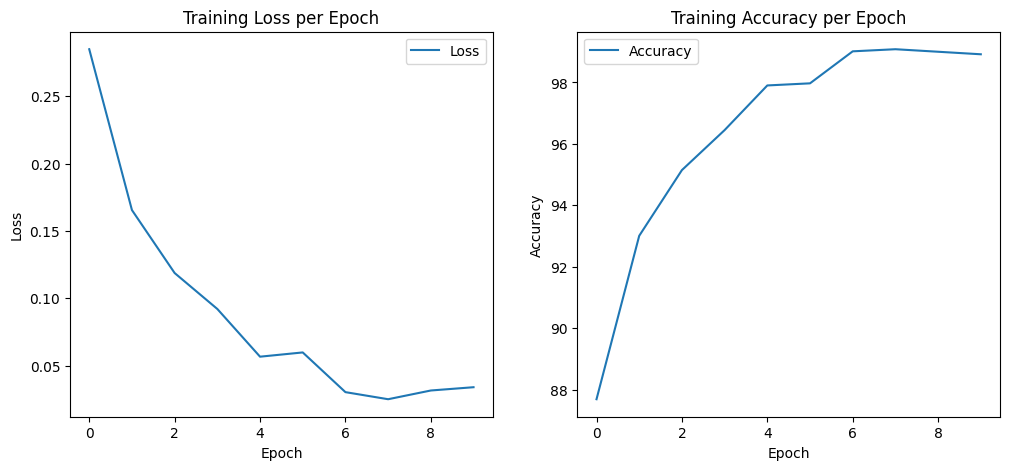

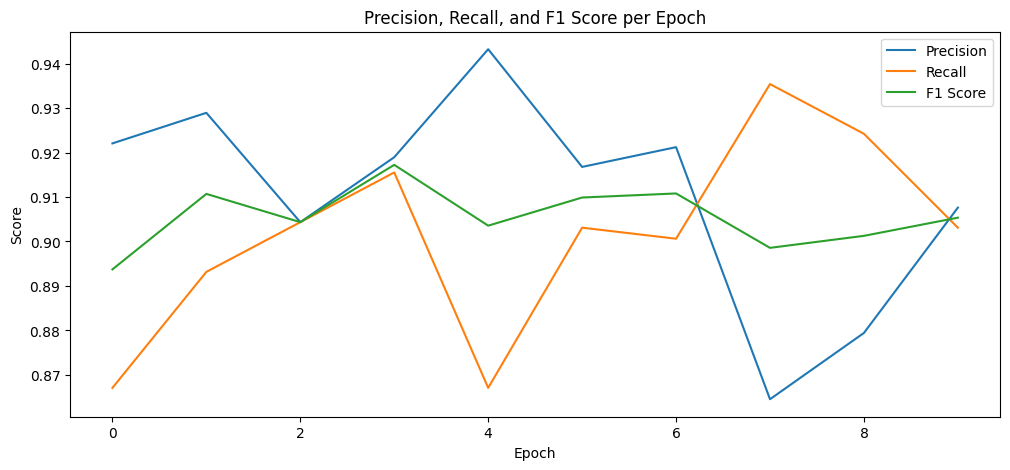

In [55]:
cnn = TweetSuicidalClfCNN()
train_dataset = TweetSuicidalDataset(X_train, y_train)
test_dataset = TweetSuicidalDataset(X_test, y_test)

clf_cnn_trainer = TweetSuicidalClfCNNTrainer(cnn=cnn,
                                             train_dataset=train_dataset,
                                             test_dataset=test_dataset)
clf_cnn_trainer.execute()

In [68]:
summary(cnn, (300, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 64]          57,664
              ReLU-2               [-1, 64, 64]               0
            Conv1d-3               [-1, 64, 64]          96,064
              ReLU-4               [-1, 64, 64]               0
            Conv1d-5               [-1, 64, 64]         134,464
              ReLU-6               [-1, 64, 64]               0
            Conv1d-7              [-1, 128, 64]          24,704
              ReLU-8              [-1, 128, 64]               0
            Conv1d-9              [-1, 128, 64]          41,088
             ReLU-10              [-1, 128, 64]               0
           Conv1d-11              [-1, 128, 64]          57,472
             ReLU-12              [-1, 128, 64]               0
        MaxPool1d-13              [-1, 128, 16]               0
        MaxPool1d-14              [-1, 

## Context Window

In the context of Convolutional Neural Networks (CNNs), a "context window" refers to the size of the input region that the convolutional filter or kernel considers when performing the convolution operation.

### Increasing Context Window

Increasing the context window beyond the length of all sentences in the dataset can have both advantages and disadvantages:

* **Pros**:

    * **Capture Longer Dependencies**: A larger context window allows the model to capture longer-term dependencies and relationships between words or tokens in the input sequence. This can be beneficial for tasks where understanding the broader context is crucial, such as in document classification, sentiment analysis, or machine translation.

    * **Global Information**: With a larger context window, the model can access more global information from the input data, potentially leading to better generalization and performance, especially for complex tasks.

    * **Reduced Information Loss**: A larger context window reduces the information loss at the edges of the input sequence. It ensures that more input tokens contribute to the computation of features, which can lead to more robust representations.

* **Cons**:

  * **Increased Computational Complexit**y: Larger context windows require processing more input tokens at each step, leading to increased computational complexity and longer training and inference times. This can make training and deploying models slower and more resource-intensive.

  * **Risk of Overfitting**: A larger context window may increase the risk of overfitting, especially if the model learns to rely too heavily on specific long-range dependencies that are present in the training data but may not generalize well to unseen data.

  * **Difficulty in Capturing Local Patterns**: While larger context windows capture longer dependencies, they may also make it harder for the model to capture local patterns and nuances within the input sequence. This can be detrimental for tasks where local context is crucial, such as named entity recognition or part-of-speech tagging.

  * **Memory Constraints**: In practical scenarios, there might be memory constraints that limit the size of the context window, especially in resource-constrained environments or when dealing with large datasets.

In summary, increasing the context window beyond the length of all sentences in the dataset can be advantageous for capturing long-range dependencies and global information but may also introduce challenges related to computational complexity, overfitting, and the capture of local patterns. The choice of context window size should be carefully considered based on the specific requirements of the task and the characteristics of the dataset.

#### Implementation

In [31]:
tweet_features_vector_v2 = twitter_suicidal_data_cleaned['tokens'].apply(
    get_tweet_features_vector, tweet_token_length=196)

In [32]:
tweet_features_vector_v2

0       [[-0.06787109375, 0.09521484375, 0.03564453125...
1       [[0.234375, -0.02294921875, 0.1826171875, 0.12...
2       [[-0.07568359375, 0.03369140625, -0.0649414062...
3       [[0.1123046875, 0.018310546875, 0.0771484375, ...
4       [[-0.0556640625, 0.01373291015625, -0.14160156...
                              ...                        
9114    [[-0.2255859375, -0.032470703125, 0.0402832031...
9115    [[-0.02490234375, -0.37890625, 0.330078125, 0....
9116    [[-0.057861328125, 0.01318359375, 0.115234375,...
9117    [[0.02392578125, -0.046142578125, 0.00390625, ...
9118    [[-0.1240234375, 0.2470703125, 0.0218505859375...
Name: tokens, Length: 9119, dtype: object

In [37]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(tweet_features_vector_v2,
                                                                twitter_suicidal_data_cleaned['intention'],
                                                                test_size=0.2,
                                                                random_state=42)
X_train_v2.reset_index(drop=True, inplace=True)
X_test_v2.reset_index(drop=True, inplace=True)
y_train_v2.reset_index(drop=True, inplace=True)
y_test_v2.reset_index(drop=True, inplace=True)

Epoch [1/10], Loss: 0.2804, Accuracy: 88.09%
Epoch [2/10], Loss: 0.1735, Accuracy: 92.87%
Epoch [3/10], Loss: 0.1543, Accuracy: 93.74%
Epoch [4/10], Loss: 0.0749, Accuracy: 97.07%
Epoch [5/10], Loss: 0.0413, Accuracy: 98.62%
Epoch [6/10], Loss: 0.0262, Accuracy: 99.16%
Epoch [7/10], Loss: 0.0357, Accuracy: 98.93%
Epoch [8/10], Loss: 0.0300, Accuracy: 99.11%
Epoch [9/10], Loss: 0.0483, Accuracy: 98.46%
Epoch [10/10], Loss: 0.0189, Accuracy: 99.34%


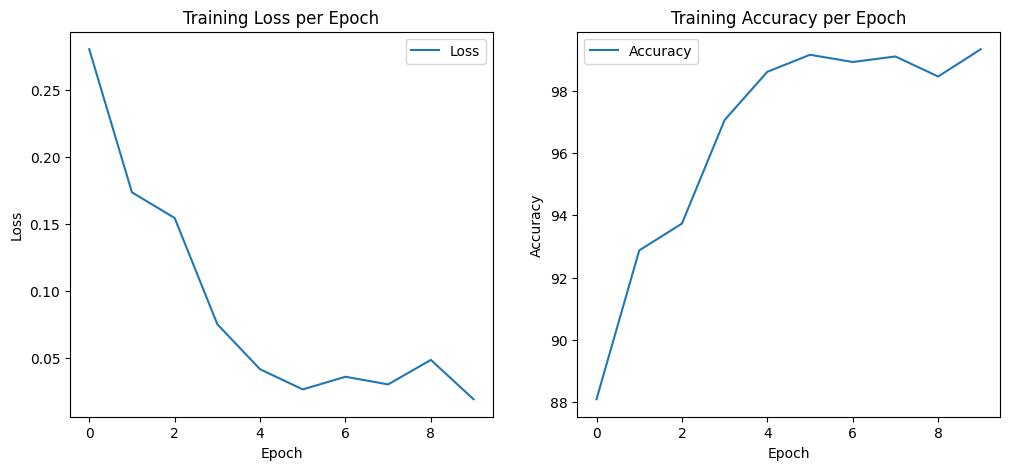

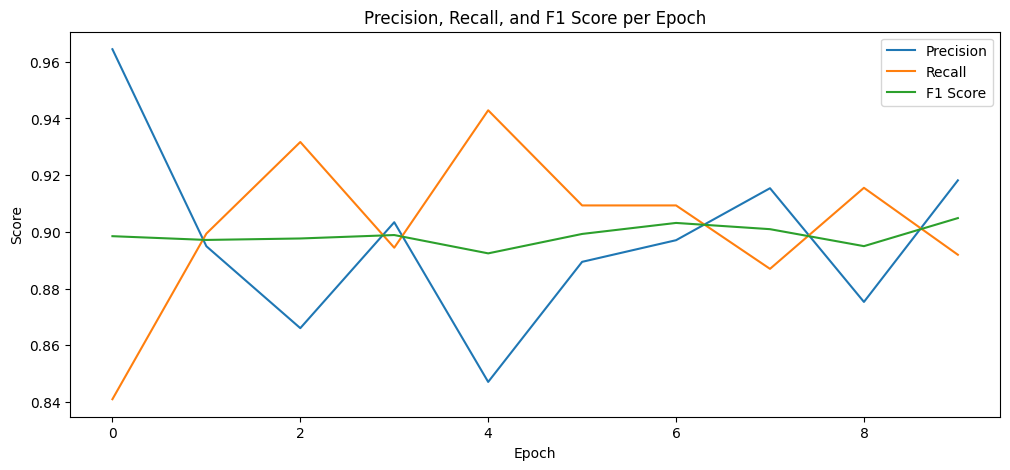

In [38]:
cnn_v2 = TweetSuicidalClfCNN()
train_dataset_v2 = TweetSuicidalDataset(X_train_v2, y_train_v2)
test_dataset_v2 = TweetSuicidalDataset(X_test_v2, y_test_v2)

clf_cnn_trainer = TweetSuicidalClfCNNTrainer(cnn=cnn_v2,
                                             train_dataset=train_dataset_v2,
                                             test_dataset=test_dataset_v2)
clf_cnn_trainer.execute()

In [47]:
summary(cnn_v2, (300, 196))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 196]          57,664
              ReLU-2              [-1, 64, 196]               0
            Conv1d-3              [-1, 64, 196]          96,064
              ReLU-4              [-1, 64, 196]               0
            Conv1d-5              [-1, 64, 196]         134,464
              ReLU-6              [-1, 64, 196]               0
            Conv1d-7             [-1, 128, 196]          24,704
              ReLU-8             [-1, 128, 196]               0
            Conv1d-9             [-1, 128, 196]          41,088
             ReLU-10             [-1, 128, 196]               0
           Conv1d-11             [-1, 128, 196]          57,472
             ReLU-12             [-1, 128, 196]               0
        MaxPool1d-13              [-1, 128, 49]               0
        MaxPool1d-14              [-1, 

As you can see above, the accuracy of the model does not change, but the complexity of time and space increases significantly.

## Regularization

Dropout and batch normalization are two techniques commonly used in training neural networks to improve their performance and generalization.

* **Dropout**: Dropout is a regularization technique used during training to prevent overfitting. It works by randomly dropping out (setting to zero) a fraction of the input units (or neurons) of a layer during each training iteration. This helps prevent co-adaptation of neurons and encourages the network to learn more robust features, reducing the likelihood of overfitting. Dropout is usually applied after the activation function.

* **Batch Normalization**: Batch normalization is a technique used to stabilize and accelerate the training of deep neural networks. It works by normalizing the input of each layer to have zero mean and unit variance, which helps mitigate the internal covariate shift problem. Batch normalization is usually applied before the activation function. It also introduces learnable parameters (gamma and beta) for scaling and shifting the normalized values, allowing the model to learn the optimal normalization for each layer.

In summary, dropout helps prevent overfitting by randomly dropping out neurons during training, while batch normalization helps stabilize and accelerate training by normalizing the input of each layer and introducing learnable parameters for scaling and shifting. Both techniques are commonly used together in modern neural network architectures to improve performance and generalization.

### Implementation

In [52]:
class RegularizedTweetSuicidalClfCNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(RegularizedTweetSuicidalClfCNN, self).__init__()

        self.conv1a = nn.Conv1d(in_channels=300,
                                out_channels=64,
                                kernel_size=3,
                                padding=1)
        self.conv1b = nn.Conv1d(in_channels=300,
                                out_channels=64,
                                kernel_size=5,
                                padding=2)
        self.conv1c = nn.Conv1d(in_channels=300,
                                out_channels=64,
                                kernel_size=7,
                                padding=3)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)

        self.conv2a = nn.Conv1d(in_channels=64,
                                out_channels=128,
                                kernel_size=3,
                                padding=1)
        self.conv2b = nn.Conv1d(in_channels=64,
                                out_channels=128,
                                kernel_size=5,
                                padding=2)
        self.conv2c = nn.Conv1d(in_channels=64,
                                out_channels=128,
                                kernel_size=7,
                                padding=3)

        self.fc1 = nn.Linear(in_features=128 * 3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

        self.dropout = nn.Dropout(dropout_prob)
        self.bn = nn.BatchNorm1d(128)

    def forward(self, x):
        x1 = self.relu(self.conv1a(x))
        x2 = self.relu(self.conv1b(x))
        x3 = self.relu(self.conv1c(x))

        x1 = self.relu(self.conv2a(x1))
        x2 = self.relu(self.conv2b(x2))
        x3 = self.relu(self.conv2c(x3))

        x1 = self.pool(x1)
        x2 = self.pool(x2)
        x3 = self.pool(x3)

        x1 = x1.max(dim=2)[0]
        x2 = x2.max(dim=2)[0]
        x3 = x3.max(dim=2)[0]

        x = torch.cat((x1, x2, x3), dim=1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.bn(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [ ]:
cnn_regularized = RegularizedTweetSuicidalClfCNN()
train_dataset = TweetSuicidalDataset(X_train, y_train)
test_dataset = TweetSuicidalDataset(X_test, y_test)
clf_cnn_trainer = TweetSuicidalClfCNNTrainer(cnn=cnn_regularized,
                                             train_dataset=train_dataset,
                                             test_dataset=test_dataset)
clf_cnn_trainer.execute()

In [ ]:
cnn_regularized.summary()